### Exercise: Fashion MNIST Classification

**Your Task**: Adapt the CNN model we've built to classify the Fashion MNIST dataset.

The Fashion MNIST dataset consists of 28×28 grayscale images of 10 fashion categories:
- 0: T-shirt/top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle boot

**Steps**:
1. Load the Fashion MNIST dataset instead of regular MNIST
2. Adapt the CNN model if necessary (you might want to use more filters or deeper architecture for this more complex dataset)
3. Train and evaluate the model
4. Visualize the results and compare with the digit classification results

**Hint**: You can load Fashion MNIST using `torchvision.datasets.FashionMNIST` instead of `datasets.MNIST`.

In [1]:
!pip install pytorch-lightning

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\giuli\PycharmProjects\DataScience\.env\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | conv1     | Conv2d             | 320    | train
1 | conv2     | Conv2d             | 18.5 K

Sanity Checking: |                                           | 0/? [00:00<?, ?it/s]

C:\Users\giuli\PycharmProjects\DataScience\.env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\giuli\PycharmProjects\DataScience\.env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                  | 0/? [00:00<?, ?it/s]

Validation: |                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                | 0/? [00:00<?, ?it/s]

Validation: |                                                | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
C:\Users\giuli\PycharmProjects\DataScience\.env\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |                                                   | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9174000024795532
        test_loss            0.251870334148407
────────────────────────────────────────────────────────────────────────────────────


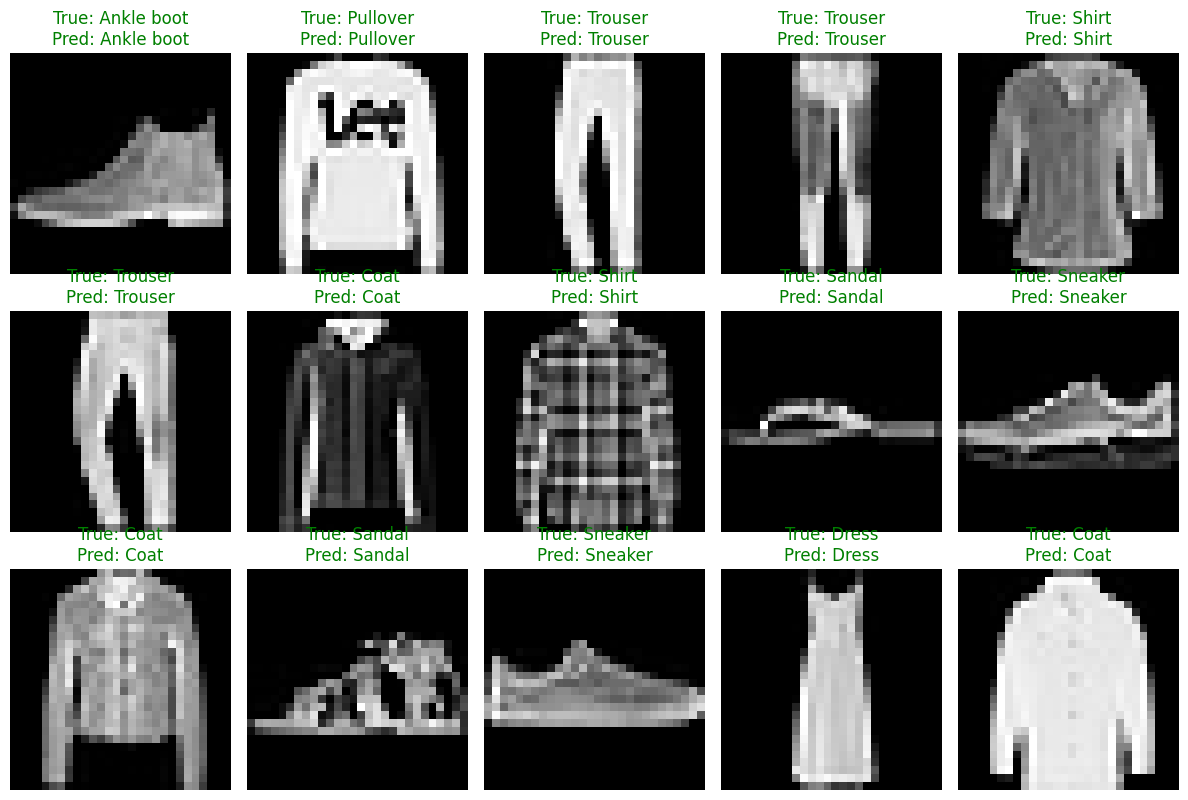

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import pytorch_lightning as pl
from torchmetrics import Accuracy  # Import da torchmetrics invece che pytorch_lightning
import matplotlib.pyplot as plt

# Definizione delle trasformazioni
fashion_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

# DataModule
class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", batch_size=64, num_workers=4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        datasets.FashionMNIST(self.data_dir, train=True, download=True)
        datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        dataset = datasets.FashionMNIST(self.data_dir, train=True, transform=fashion_transform)
        self.train_data, self.val_data = random_split(dataset, [50000, 10000])
        self.test_data = datasets.FashionMNIST(self.data_dir, train=False, transform=fashion_transform)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, 
                         shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self): 
        return DataLoader(self.val_data, batch_size=self.batch_size, 
                         num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, 
                         num_workers=self.num_workers)

# Modello CNN
class FashionMNISTClassifierCNN(pl.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
        # Metriche da torchmetrics
        self.train_acc = Accuracy(task='multiclass', num_classes=num_classes)
        self.val_acc = Accuracy(task='multiclass', num_classes=num_classes)
        self.test_acc = Accuracy(task='multiclass', num_classes=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_acc(logits, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("train_acc", self.train_acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_acc(logits, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.test_acc(logits, y)
        self.log("test_loss", loss)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

# Funzione di visualizzazione
def visualize_predictions(model, dataloader, class_names):
    model.eval()
    images, labels = next(iter(dataloader))
    with torch.no_grad():
        outputs = model(images)
    preds = outputs.argmax(dim=1)
    
    fig, axes = plt.subplots(3, 5, figsize=(12, 8))
    axes = axes.flatten()
    for img, label, pred, ax in zip(images[:15], labels[:15], preds[:15], axes):
        img = img.squeeze().numpy()
        ax.imshow(img, cmap="gray")
        ax.set_title(f"True: {class_names[label.item()]}\nPred: {class_names[pred.item()]}", 
                    color='green' if label == pred else 'red')
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Esecuzione
if __name__ == "__main__":
    fashion_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    data_module = FashionMNISTDataModule(batch_size=64, num_workers=4)
    model = FashionMNISTClassifierCNN()
    
# Configurazione del Trainer corretta
    trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto" if torch.cuda.is_available() else 1,  # 1 per CPU, "auto" per GPU
    enable_progress_bar=True
)
    
    trainer.fit(model, datamodule=data_module)
    trainer.test(model, datamodule=data_module)
    
    test_dataloader = data_module.test_dataloader()
    visualize_predictions(model, test_dataloader, fashion_class_names)

I have adapted the code for Fashion MNIST classification, including:

FashionMNISTDataModule: Similar to MNISTDataModule but using Fashion MNIST data.

FashionMNISTClassifierCNN: A deeper CNN with three convolutional layers to better handle the increased complexity of the images.

Training and evaluation process: Using PyTorch Lightning for efficient training.

**I reached epoch 9, with a validation accuracy of 92.7% and a loss of 0.236. After training, the accuracy on the test data is 91.74% with a loss of 0.252.** This indicates a good result on both the validation and test sets.